In [7]:
import requests
import base64
import os
import jwt
import time
import sqlite3
import json
import re
import concurrent.futures

def get_jwt():
    """fetch the jwt token object"""
    headers = {
        'User-Agent': 'Jobsuche/2.9.2 (de.arbeitsagentur.jobboerse; build:1077; iOS 15.1.0) Alamofire/5.4.4',
        'Host': 'rest.arbeitsagentur.de',
        'Connection': 'keep-alive',
        'Content-Type': 'application/x-www-form-urlencoded; charset=utf-8',
    }

    data = {
      'client_id': 'c003a37f-024f-462a-b36d-b001be4cd24a',
      'client_secret': '32a39620-32b3-4307-9aa1-511e3d7f48a8',
      'grant_type': 'client_credentials'
    }

    response = requests.post('https://rest.arbeitsagentur.de/oauth/gettoken_cc', headers=headers, data=data, verify=True) #, verify=True

    return response.json()

def search(jwt, angebotsart, page, size):
    params = {
        'angebotsart': angebotsart,
        'page': str(page),
        'size' : size,
    }

    headers = {
       'User-Agent': 'Jobsuche/2.9.2 (de.arbeitsagentur.jobboerse; build:1077; iOS 15.1.0) Alamofire/5.4.4',
        'Host': 'rest.arbeitsagentur.de',
        'OAuthAccessToken': jwt,
        'Connection': 'keep-alive',
    }

    response = requests.get('https://rest.arbeitsagentur.de/jobboerse/jobsuche-service/pc/v4/app/jobs',
                            headers=headers, params=params, verify=True)   #, verify=True
    return response.json()


def job_details(jwt, job_ref):

    headers = {
        'User-Agent': 'Jobsuche/2.9.3 (de.arbeitsagentur.jobboerse; build:1078; iOS 15.1.0) Alamofire/5.4.4',
        'Host': 'rest.arbeitsagentur.de',
        'OAuthAccessToken': jwt,
        'Connection': 'keep-alive',
    }

    response = requests.get(
        f'https://rest.arbeitsagentur.de/jobboerse/jobsuche-service/pc/v2/jobdetails/{(base64.b64encode(job_ref.encode())).decode("UTF-8")}',
        headers=headers, verify=True)  #, verify=False

    return response.json()



def create_table(conn, table_name):
    
    cursor = conn.cursor()

    # Create the job_listing table if it doesn't exist
    cursor.execute(f'''
        CREATE TABLE IF NOT EXISTS {table_name} (
            aktuelleVeroeffentlichungsdatum TEXT,
            laufzeitBis TEXT,
			angebotsart INTEGER,
            arbeitgeber TEXT,
            branchengruppe TEXT,
			branche TEXT,
            arbeitsorte_land TEXT,
			arbeitsorte_region TEXT,
			arbeitsorte_plz INTEGER,
			arbeitsorte_ort TEXT,
            arbeitsorte_koordinaten_lat REAL,
            arbeitsorte_koordinaten_lon REAL,
            arbeitszeitmodelle TEXT,
            befristung TEXT,
			uebernahme TEXT,
			betriebsgroesse TEXT,
			eintrittsdatum TEXT,
			ersteVeroeffentlichungsdatum TEXT,
			allianzpartner  TEXT,
			allianzpartnerUrl TEXT,
			titel TEXT,
			beruf TEXT,
			modifikationsTimestamp TEXT,
			stellenbeschreibung TEXT,
			refnr TEXT PRIMARY KEY,
			fuerFluechtlingeGeeignet BOOLEAN,
			nurFuerSchwerbehinderte BOOLEAN,
			anzahlOffeneStellen TEXT,
            arbeitgeber_land TEXT,
            arbeitgeber_region TEXT,
            arbeitgeber_plz INTEGER,
            arbeitgeber_ort TEXT,
            arbeitgeber_strasse TEXT,
            arbeitgeber_strasseHausnummer TEXT,
            fertigkeiten_hierarchieName TEXT,
            fertigkeiten_auspraegungen TEXT,
            mobilitaet_reisebereitschaft TEXT,
            fuehrungskompetenzen_hatVollmacht BOOLEAN,
            fuehrungskompetenzen_hatBudgetverantwortung BOOLEAN,
            verguetung TEXT,
            arbeitgeberdarstellungUrl TEXT,
            arbeitgeberdarstellung TEXT,
            hauptDkz TEXT,
            istBetreut BOOLEAN,
            istPrivateArbeitsvermittlung BOOLEAN,
            istZeitarbeit BOOLEAN,
            istGoogleJobsRelevant BOOLEAN,
            anzeigeAnonym BOOLEAN
        )
    ''')

def insert_data_into_db(data, conn, table_name):
    
    cursor = conn.cursor()

    for entry in data:
        aktuelleVeroeffentlichungsdatum = entry.get("aktuelleVeroeffentlichungsdatum", "")
        laufzeitBis = entry.get("laufzeitBis", "")
        angebotsart = entry.get("angebotsart", "")
        arbeitgeber = entry.get("arbeitgeber", "")
        branchengruppe = entry.get("branchengruppe", "")
        branche = entry.get("branche", "")
        
        arbeitsorte = entry.get("arbeitsorte", [])
        for arbeitsort in arbeitsorte:
            arbeitsorte_land = arbeitsort.get("land")
            arbeitsorte_region = arbeitsort.get("region")
            arbeitsorte_plz = arbeitsort.get("plz")
            arbeitsorte_ort = arbeitsort.get("ort")
            arbeitsorte_koordinaten_lat = arbeitsort.get("koordinaten", {}).get("lat")
            arbeitsorte_koordinaten_lon = arbeitsort.get("koordinaten", {}).get("lon")

        arbeitszeitmodelle = entry.get("arbeitszeitmodelle", [])
        arbeitszeitmodelle_str = re.sub(r'[\[\]"]', '', str(json.dumps(arbeitszeitmodelle)))

        befristung = entry.get("befristung", "")
        uebernahme = entry.get("uebernahme", "")
        betriebsgroesse = entry.get("betriebsgroesse", "")
        eintrittsdatum = entry.get("eintrittsdatum", "")
        ersteVeroeffentlichungsdatum = entry.get("ersteVeroeffentlichungsdatum", "")
        allianzpartner = entry.get("allianzpartner", "")
        allianzpartnerUrl = entry.get("allianzpartnerUrl", "")
        titel = entry.get("titel", "")
        beruf = entry.get("beruf", "")
        modifikationsTimestamp = entry.get("modifikationsTimestamp", "")

        stellenbeschreibung = entry.get("stellenbeschreibung", "")        
        truncated_stellenbeschreibung = re.sub(r'[\[\]\-"*]', '', str(json.dumps(stellenbeschreibung[:100])))

        refnr = entry.get("refnr", "")
        fuerFluechtlingeGeeignet = entry.get("fuerFluechtlingeGeeignet", "")
        nurFuerSchwerbehinderte = entry.get("nurFuerSchwerbehinderte", "")
        anzahlOffeneStellen = entry.get("anzahlOffeneStellen", "")

        arbeitgeber_adresse = entry.get("arbeitgeberAdresse", {})
        arbeitgeber_land = arbeitgeber_adresse.get("land")
        arbeitgeber_region = arbeitgeber_adresse.get("region")
        arbeitgeber_plz = arbeitgeber_adresse.get("plz")
        arbeitgeber_ort = arbeitgeber_adresse.get("ort")
        arbeitgeber_strasse = arbeitgeber_adresse.get("strasse")
        arbeitgeber_strasseHausnummer = arbeitgeber_adresse.get("strasseHausnummer")

        fertigkeiten_hierarchieName = ""
        fertigkeiten_auspraegungen = ""

        fertigkeiten = entry.get("fertigkeiten", [])
        for fertigkeit in fertigkeiten:
            fertigkeiten_hierarchieName = fertigkeit.get("hierarchieName")
            fertigkeiten_auspraegungen = json.dumps(fertigkeit.get("auspraegungen", {}))

        # Extract "mobilitaet" data
        mobilitaet = entry.get("mobilitaet", {})
        mobilitaet_reisebereitschaft = mobilitaet.get("reisebereitschaft")

        # Extract "fuehrungskompetenzen" data
        fuehrungskompetenzen = entry.get("fuehrungskompetenzen", {})
        fuehrungskompetenzen_hatVollmacht = fuehrungskompetenzen.get("hatVollmacht")
        fuehrungskompetenzen_hatBudgetverantwortung = fuehrungskompetenzen.get("hatBudgetverantwortung")

        verguetung = entry.get("verguetung", "")
        arbeitgeberdarstellungUrl = entry.get("arbeitgeberdarstellungUrl", "")

        arbeitgeberdarstellung = entry.get("arbeitgeberdarstellung", "")
        truncated_arbeitgeberdarstellung = arbeitgeberdarstellung[:100]  # Truncate to 100 characters

        hauptDkz = entry.get("hauptDkz", "")
        istBetreut = entry.get("istBetreut", "")
        istGoogleJobsRelevant = entry.get("istGoogleJobsRelevant", "")
        anzeigeAnonym = entry.get("anzeigeAnonym", "")
        istPrivateArbeitsvermittlung = entry.get("istPrivateArbeitsvermittlung", "")
        istZeitarbeit = entry.get("istZeitarbeit", "")

        # Check if the refnr already exists in the table
        cursor.execute(f'''SELECT COUNT(*) FROM {table_name} WHERE refnr = ?''', (refnr,))
        count = cursor.fetchone()[0]

        if count == 0: 
        # Insert data into the table    
            cursor.execute(f'''INSERT INTO {table_name} (aktuelleVeroeffentlichungsdatum,laufzeitBis,angebotsart,arbeitgeber,
                           branchengruppe,branche,arbeitsorte_land,arbeitsorte_region,arbeitsorte_plz,arbeitsorte_ort,
                           arbeitsorte_koordinaten_lat,arbeitsorte_koordinaten_lon,arbeitszeitmodelle,befristung,uebernahme,
                           betriebsgroesse,eintrittsdatum,ersteVeroeffentlichungsdatum,allianzpartner ,allianzpartnerUrl,titel,beruf,
                           modifikationsTimestamp,stellenbeschreibung,refnr,fuerFluechtlingeGeeignet,nurFuerSchwerbehinderte,
                           anzahlOffeneStellen,arbeitgeber_land,arbeitgeber_region,arbeitgeber_plz, arbeitgeber_ort,arbeitgeber_strasse,
                           arbeitgeber_strasseHausnummer,fertigkeiten_hierarchieName,fertigkeiten_auspraegungen,
                           mobilitaet_reisebereitschaft,fuehrungskompetenzen_hatVollmacht,fuehrungskompetenzen_hatBudgetverantwortung,
                           verguetung,arbeitgeberdarstellungUrl,arbeitgeberdarstellung,hauptDkz,istBetreut,istPrivateArbeitsvermittlung,
                           istZeitarbeit,istGoogleJobsRelevant,anzeigeAnonym
                                                    )
                          VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''',
                            (aktuelleVeroeffentlichungsdatum,laufzeitBis,angebotsart,arbeitgeber,branchengruppe,branche,
                            arbeitsorte_land,arbeitsorte_region,arbeitsorte_plz,arbeitsorte_ort,arbeitsorte_koordinaten_lat,
                            arbeitsorte_koordinaten_lon,arbeitszeitmodelle_str,befristung,uebernahme,betriebsgroesse,
                            eintrittsdatum,ersteVeroeffentlichungsdatum,allianzpartner ,allianzpartnerUrl,titel,beruf,modifikationsTimestamp,
                            truncated_stellenbeschreibung,refnr,fuerFluechtlingeGeeignet,nurFuerSchwerbehinderte,anzahlOffeneStellen,
                            arbeitgeber_land,arbeitgeber_region,arbeitgeber_plz, arbeitgeber_ort,arbeitgeber_strasse,arbeitgeber_strasseHausnummer,
                            fertigkeiten_hierarchieName,fertigkeiten_auspraegungen ,mobilitaet_reisebereitschaft,fuehrungskompetenzen_hatVollmacht,
                            fuehrungskompetenzen_hatBudgetverantwortung,verguetung,arbeitgeberdarstellungUrl,truncated_arbeitgeberdarstellung,
                            hauptDkz,istBetreut,istPrivateArbeitsvermittlung,istZeitarbeit,istGoogleJobsRelevant,anzeigeAnonym))
    

def process_jobs(jwt, angebotsart, table_name ):
    #jwt = get_jwt()            
    try:
        conn = sqlite3.connect('weiterbildung_analysis.db')
        create_table(conn, table_name)
        
        page = 1
        #size = 100
        
        while True:
            result = search(jwt["access_token"], angebotsart, page, 100) 
            refnrs_on_page = [item["refnr"] for item in result.get('stellenangebote', [])]
                        
            if not refnrs_on_page:
                break
                
            job_details_data_list = []

            for refnr in refnrs_on_page:
                job_details_data = job_details(jwt["access_token"], refnr)
                job_details_data_list.append(job_details_data)                
        
            insert_data_into_db(job_details_data_list, conn, table_name)
        
            print("Data inserted for angebotsart" ,angebotsart, "from page:", page, "loading in table:", table_name)
            page += 1

    except Exception as e:
        print(f"Error: {e}")

    finally:
        print("Data fetched and saved to SQLite database successfully.")
        conn.commit()
        conn.close()
        
def main():
    jwt = get_jwt()
    
    process_jobs(jwt, '2', 'Jobsuche_p2')
    process_jobs(jwt, '4', 'Jobsuche_p2')
    process_jobs(jwt, '34', 'Jobsuche_p2')
    process_jobs(jwt, '1', 'Jobsuche_p2')

if __name__ == "__main__":
    main()

#2:6m27.3s(page 27)

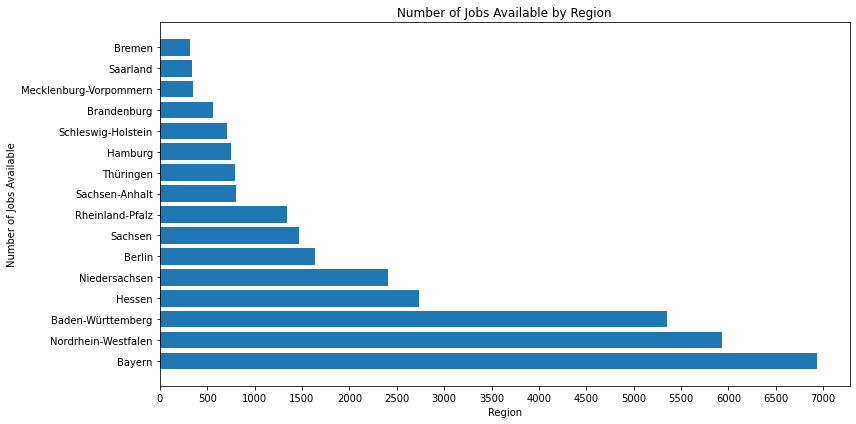

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('weiterbildung_analysis.db')  # Replace with your database path
query = """
    SELECT arbeitsorte_region AS Region, COUNT(*) AS Count
    FROM Jobsuche_p2
    GROUP BY arbeitsorte_region
    HAVING COUNT(*) >= 100
    ORDER BY Count DESC;

"""

# Execute the SQL query and load the results into a DataFrame
df = pd.read_sql_query(query, conn)
#print(df)
# Filter out rows with None values in the 'Region' column
df = df[df['Region'].notna()]

# Plotting the data
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.barh(df['Region'], df['Count'])
plt.xlabel('Region')
plt.ylabel('Number of Jobs Available')
plt.title('Number of Jobs Available by Region')

# Manually set x-axis ticks in intervals (0-500-1000)
x_ticks = range(0, max(df['Count']) + 500, 500)
plt.xticks(x_ticks)
# Display the plot
plt.tight_layout()
plt.show()


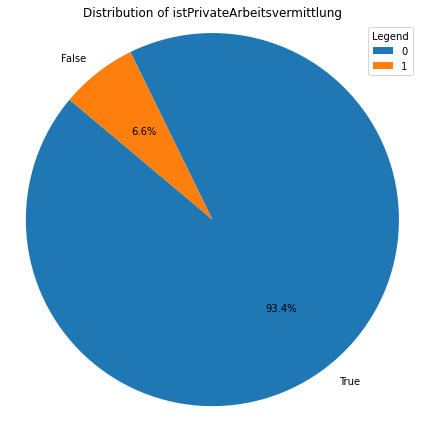

In [9]:
# Query to retrieve the count of 'true' and 'false' values in the column
query = """
    SELECT istPrivateArbeitsvermittlung, COUNT(*) AS Count
    FROM Jobsuche_p2
    GROUP BY istPrivateArbeitsvermittlung
"""

# Execute the SQL query and load the results into a DataFrame
df = pd.read_sql_query(query, conn)

# Create a pie chart
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.pie(df['Count'], labels=['True', 'False'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of istPrivateArbeitsvermittlung')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a legend
plt.legend(df['istPrivateArbeitsvermittlung'], title='Legend', loc='best')

# Display the pie chart
plt.tight_layout()
plt.show()


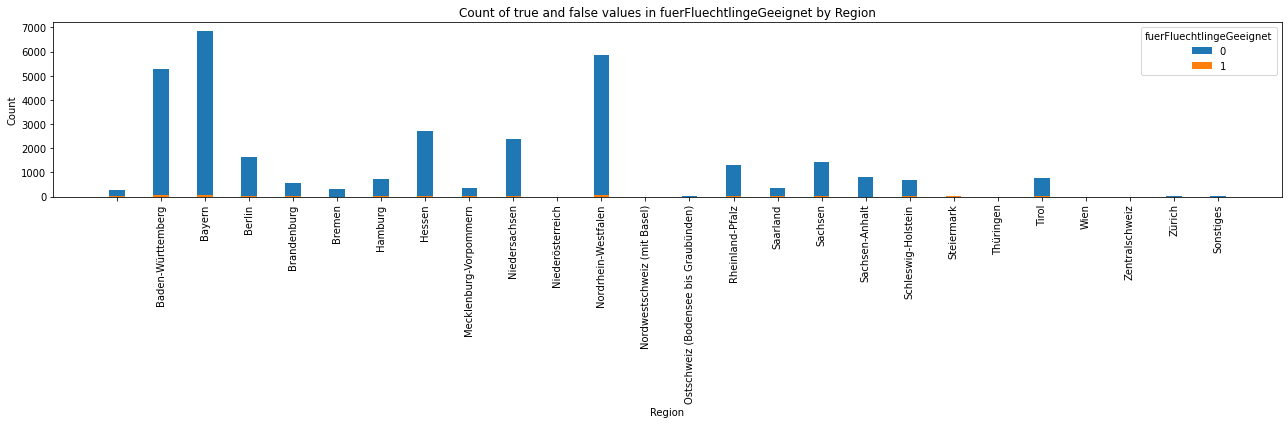

In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Connect to the SQLite database
conn = sqlite3.connect('weiterbildung_analysis.db')  # Replace with your database path

# Query to retrieve the count of 'true' and 'false' values in the column by region
query = """
    SELECT fuerFluechtlingeGeeignet, arbeitsorte_region AS Region, COUNT(*) AS Count
    FROM Jobsuche_p2
    GROUP BY fuerFluechtlingeGeeignet, Region
"""

# Execute the SQL query and load the results into a DataFrame
df = pd.read_sql_query(query, conn)

# Pivot the DataFrame to have 'true' and 'false' values as columns
pivot_df = df.pivot(index='Region', columns='fuerFluechtlingeGeeignet', values='Count').fillna(0)

# Get unique regions
regions = df['Region'].unique()

# Create a bar graph with side-by-side bars for each region
num_regions = len(regions)
width = 0.35  # Width of each bar
x = np.arange(num_regions)  # x-axis values for regions

plt.figure(figsize=(18, 6))  # Adjust the figure size as needed

for label in pivot_df.columns:
    plt.bar(x, pivot_df[label], width, label=label)

plt.xlabel('Region')
plt.ylabel('Count')
plt.title('Count of true and false values in fuerFluechtlingeGeeignet by Region')
plt.xticks(x, regions, rotation=90)  # Set x-axis labels as region names
plt.legend(title='fuerFluechtlingeGeeignet')

# Display the plot
plt.tight_layout()
plt.show()


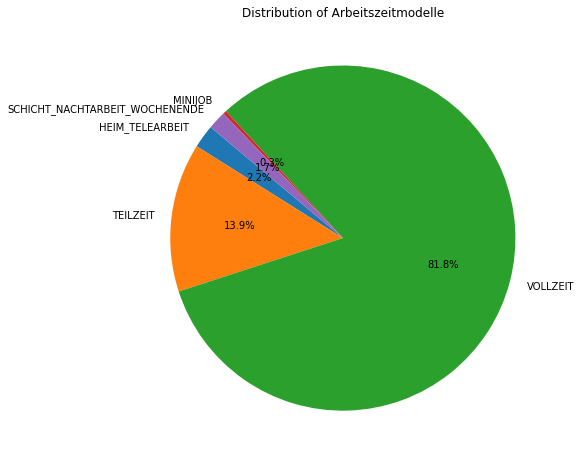

In [11]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('weiterbildung_analysis.db')  # Replace with your database path

# Query to retrieve the count of each value in the 'arbeitszeitmodelle' column
query = """
    SELECT
        SUM(CASE WHEN arbeitszeitmodelle LIKE '%HEIM_TELEARBEIT%' THEN 1 ELSE 0 END) AS HEIM_TELEARBEIT,
        SUM(CASE WHEN arbeitszeitmodelle LIKE '%TEILZEIT%' THEN 1 ELSE 0 END) AS TEILZEIT,
        SUM(CASE WHEN arbeitszeitmodelle LIKE '%VOLLZEIT%' THEN 1 ELSE 0 END) AS VOLLZEIT,
        SUM(CASE WHEN arbeitszeitmodelle LIKE '%MINIJOB%' THEN 1 ELSE 0 END) AS MINIJOB,
        SUM(CASE WHEN arbeitszeitmodelle LIKE '%SCHICHT_NACHTARBEIT_WOCHENENDE%' THEN 1 ELSE 0 END) AS SCHICHT_NACHTARBEIT_WOCHENENDE
    FROM Jobsuche_p2
"""

# Execute the SQL query and load the results into a DataFrame
df = pd.read_sql_query(query, conn)

# Transpose the DataFrame for better visualization
df = df.transpose()

# Create a pie chart
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.pie(df[0], labels=df.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Arbeitszeitmodelle')

# Display the pie chart
plt.tight_layout()
plt.show()


In [12]:
import sqlite3
import pandas as pd
import folium

# Connect to the SQLite database
conn = sqlite3.connect('weiterbildung_analysis.db')  # Replace with your database path

# Query to retrieve relevant columns and filter by job count
query = """
    SELECT
        arbeitsorte_region AS Region,
        arbeitsorte_koordinaten_lat AS Latitude,
        arbeitsorte_koordinaten_lon AS Longitude
    FROM Jobsuche_p2
    WHERE angebotsart = 2;
"""

# Execute the SQL query and load the results into a DataFrame
df = pd.read_sql_query(query, conn)

# Create a map centered at a specific location (you can adjust the coordinates)
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Add circle markers for each job location and display additional job details
for index, row in df.iterrows():
    popup_text = f"""
    <b>Region:</b> {row['Region']}<br>
    <b>Latitude:</b> {row['Latitude']}<br>
    <b>Longitude:</b> {row['Longitude']}<br>
    
    """
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,  # Adjust the radius as needed
        color='blue',  # Marker color
        fill=True,
        fill_color='blue',  # Fill color
        fill_opacity=0.6,
        popup=folium.Popup(popup_text, max_width=300),
    ).add_to(m)

# Display the map
m.save('job_locations.html')  # Save the map to an HTML file
